In [28]:
import pandas as pd

# Load the data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merging the datasets based on CustomerID (assuming CustomerID is the common column)
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')

# Show the first few rows to understand the structure
merged_df.head()




,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04


In [29]:
# Convert 'SignupDate' to datetime
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])

# Derive AccountAge (in days)
merged_df['AccountAge'] = (pd.to_datetime('today') - merged_df['SignupDate']).dt.days

# One-hot encode 'Region' column (assuming it contains categorical data like 'North America', 'Europe', etc.)
merged_df = pd.get_dummies(merged_df, columns=['Region'], drop_first=True)

# Show the updated dataframe with the new features
merged_df[['CustomerID', 'AccountAge', 'TotalValue', 'Quantity'] + [col for col in merged_df.columns if 'Region' in col]].head()






,CustomerID,AccountAge,TotalValue,Quantity,Region_Europe,Region_North America,Region_South America
0,C0199,786,300.68,1,1,0,0
1,C0199,786,550.16,4,1,0,0
2,C0199,786,834.74,2,1,0,0
3,C0199,786,293.70,2,1,0,0
4,C0146,145,300.68,1,0,0,0


In [7]:
# Selecting relevant features for clustering
# Assuming that 'AccountAge' is the profile feature and 'TotalValue' and 'Quantity' are transaction features
# Using the region columns for encoding categorical features if required

features = merged_df[['AccountAge', 'TotalValue', 'Quantity', 'Region_Europe', 'Region_North America', 'Region_South America']]

# If Region columns are binary (0 or 1), you can directly include them. Otherwise, you might need to one-hot encode them
# If needed, you can one-hot encode categorical columns like 'Region' (for example, if you have a 'Region' column)
# features = pd.get_dummies(merged_df[['Region']], drop_first=True) 

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Display the first few rows of scaled features
print(scaled_features[:5])




[[ 0.66355225 -0.7898504  -1.37548802  1.80928281 -0.56811207 -0.66089455]
 [ 0.66355225 -0.2837009   1.30926413  1.80928281 -0.56811207 -0.66089455]
 [ 0.66355225  0.29366012 -0.48057063  1.80928281 -0.56811207 -0.66089455]
 [ 0.66355225 -0.80401155 -0.48057063  1.80928281 -0.56811207 -0.66089455]
 [-1.28647935 -0.7898504  -1.37548802 -0.55270519 -0.56811207 -0.66089455]]


In [30]:
from sklearn.preprocessing import StandardScaler

# Selecting the relevant features for clustering
features = merged_df[['AccountAge', 'TotalValue', 'Quantity'] + [col for col in merged_df.columns if 'Region' in col]]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Check the scaled data
X_scaled[:5]  # Preview the scaled features



array([[ 0.66355225, -0.7898504 , -1.37548802,  1.80928281, -0.56811207,
        -0.66089455],
       [ 0.66355225, -0.2837009 ,  1.30926413,  1.80928281, -0.56811207,
        -0.66089455],
       [ 0.66355225,  0.29366012, -0.48057063,  1.80928281, -0.56811207,
        -0.66089455],
       [ 0.66355225, -0.80401155, -0.48057063,  1.80928281, -0.56811207,
        -0.66089455],
       [-1.28647935, -0.7898504 , -1.37548802, -0.55270519, -0.56811207,
        -0.66089455]])

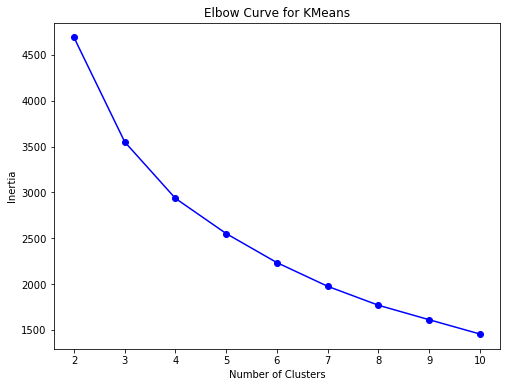

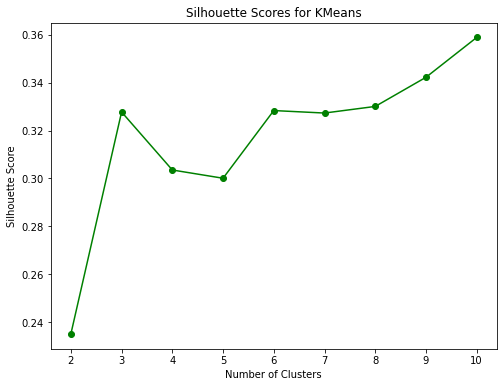

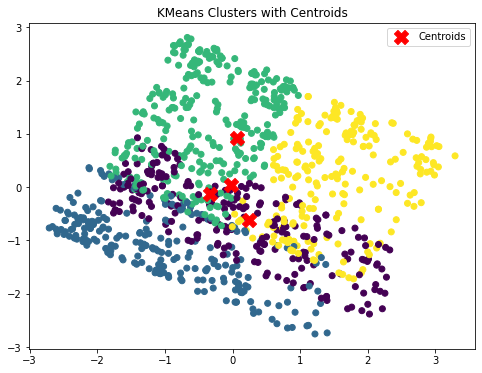

DB Index for KMeans: 1.3565614909677495


In [31]:
# Apply KMeans Clustering with different number of clusters (2 to 10)
inertia = []
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    
    # Calculate inertia and silhouette score for each cluster configuration
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='b')
plt.title("Elbow Curve for KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='g')
plt.title("Silhouette Scores for KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Let's assume optimal clusters = 4 (based on the elbow and silhouette analysis)
kmeans = KMeans(n_clusters=4, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster centroids
centroids = kmeans.cluster_centers_

# Visualizing the clusters (2D using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_df['Cluster'], cmap='viridis', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', label="Centroids")
plt.title("KMeans Clusters with Centroids")
plt.legend()
plt.show()

# Calculate Davies-Bouldin Index for KMeans
db_index_kmeans = davies_bouldin_score(X_scaled, merged_df['Cluster'])
print(f"DB Index for KMeans: {db_index_kmeans}")


Silhouette Score for DBSCAN: 0.15792526787068845


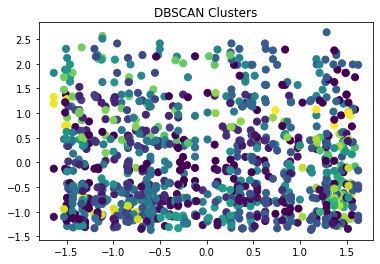

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# DBSCAN requires two key parameters: eps (distance threshold) and min_samples (minimum samples per cluster)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can tune these parameters based on the data
merged_df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Calculate Silhouette Score for DBSCAN
silhouette_dbscan = silhouette_score(X_scaled, merged_df['DBSCAN_Cluster'])
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan}")

# Visualizing DBSCAN clusters (Ignoring noise labeled as -1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=merged_df['DBSCAN_Cluster'], cmap='viridis', marker='o', s=50)
plt.title("DBSCAN Clusters")
plt.show()


Silhouette Score for Agglomerative Clustering: 0.28023793253616425


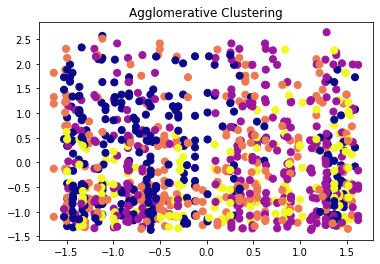

In [33]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)  # You can try different cluster numbers
merged_df['Agglo_Cluster'] = agglo.fit_predict(X_scaled)

# Calculate Silhouette Score for Agglomerative Clustering
silhouette_agglo = silhouette_score(X_scaled, merged_df['Agglo_Cluster'])
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agglo}")

# Visualizing Agglomerative Clustering results
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=merged_df['Agglo_Cluster'], cmap='plasma', marker='o', s=50)
plt.title("Agglomerative Clustering")
plt.show()



In [22]:
# Cluster distribution
print(merged_df['Cluster'].value_counts())


2    300
1    244
0    234
3    222
Name: Cluster, dtype: int64


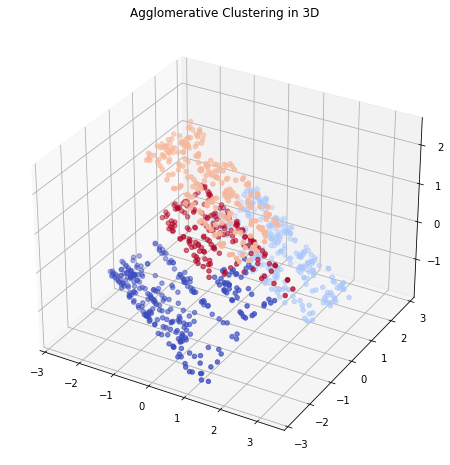

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce data to 3 dimensions for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Visualize in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=merged_df['Agglo_Cluster'], cmap='coolwarm')
ax.set_title("Agglomerative Clustering in 3D")
plt.show()


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


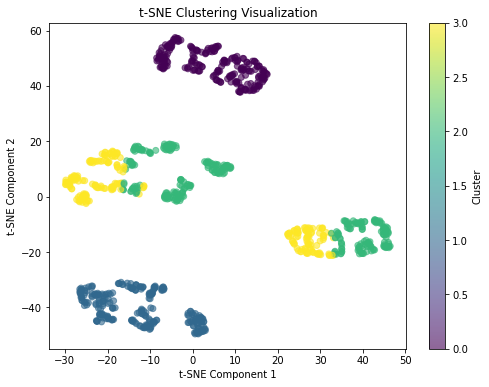

In [16]:
from sklearn.manifold import TSNE

# Reduce dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE results with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('t-SNE Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [35]:
from sklearn.metrics import davies_bouldin_score

# Compute Davies-Bouldin Index for DBSCAN
db_index_dbscan = davies_bouldin_score(X_scaled, merged_df['DBSCAN_Cluster'])
print(f"DB Index for DBSCAN: {db_index_dbscan}")

# Compute Davies-Bouldin Index for Agglomerative Clustering
db_index_agglo = davies_bouldin_score(X_scaled, merged_df['Agglo_Cluster'])
print(f"DB Index for Agglomerative Clustering: {db_index_agglo}")


DB Index for DBSCAN: 1.2459256865047212
DB Index for Agglomerative Clustering: 1.4672600205384352
